In [ ]:
## Notebook env: brian_script_env (R kernel)

In [1]:
library(ggplot2)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(tidyverse)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.4.0     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ dplyr::combine()    masks gridExtra::combine()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [2]:
## load patient metadata
meta = read.csv('/home/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_bcr_clinical_data_patient.txt', skip = 4, sep='\t')

## classify patients into subtypes
meta_luminal_A = meta %>% filter(ER_STATUS_BY_IHC == 'Positive' | PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Negative')
meta_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Positive')
meta_tnbc = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Negative')
meta_luminal_B_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Positive', PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Positive')

meta_luminal_A$PATIENT_ID = paste0(str_replace_all(meta_luminal_A$PATIENT_ID, '-', '.'), '.01')
meta_her2$PATIENT_ID = paste0(str_replace_all(meta_her2$PATIENT_ID, '-', '.'), '.01')
meta_tnbc$PATIENT_ID = paste0(str_replace_all(meta_tnbc$PATIENT_ID, '-', '.'), '.01')
meta_luminal_B_her2$PATIENT_ID = paste0(str_replace_all(meta_luminal_B_her2$PATIENT_ID, '-', '.'), '.01')

## Get patient subtype counts
paste('Luminal A patients:', nrow(meta_luminal_A))
paste('HER2+ patients:', nrow(meta_her2))
paste('Triple negative patients:', nrow(meta_tnbc))
paste('Luminal B with HER2+ patients:', nrow(meta_luminal_B_her2))

[1] "Luminal A patients: 445"

[1] "HER2+ patients: 37"

[1] "Triple negative patients: 116"

[1] "Luminal B with HER2+ patients: 100"

In [3]:
## load in data
RNA_Seq_expression_raw_data <- read.delim("/home/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_RNA_Seq_v2_expression_median.txt", stringsAsFactors = FALSE)

## subset breast cancer patients by type here
RNA_Seq_expression_raw_data_luminal_A = RNA_Seq_expression_raw_data %>% select(any_of(c('Hugo_Symbol', 'Entrez_Gene_Id', meta_luminal_A$PATIENT_ID))) %>% as.data.frame()
RNA_Seq_expression_raw_data_her2 = RNA_Seq_expression_raw_data %>% select(any_of(c('Hugo_Symbol', 'Entrez_Gene_Id', meta_her2$PATIENT_ID))) %>% as.data.frame()
RNA_Seq_expression_raw_data_tnbc = RNA_Seq_expression_raw_data %>% select(any_of(c('Hugo_Symbol', 'Entrez_Gene_Id', meta_tnbc$PATIENT_ID))) %>% as.data.frame()
RNA_Seq_expression_raw_data_luminal_B_her2 = RNA_Seq_expression_raw_data %>% select(any_of(c('Hugo_Symbol', 'Entrez_Gene_Id', meta_luminal_B_her2$PATIENT_ID))) %>% as.data.frame()

In [4]:
RNA_Seq_expression_raw_data_luminal_A = RNA_Seq_expression_raw_data_luminal_A %>% filter(Hugo_Symbol %in% c('RNF8', 'MIS18A')) %>% select(-Entrez_Gene_Id) %>% group_by(Hugo_Symbol) %>% pivot_longer(-Hugo_Symbol, names_to = 'Patient', values_to = 'Expression')
RNA_Seq_expression_raw_data_her2 = RNA_Seq_expression_raw_data_her2 %>% filter(Hugo_Symbol %in% c('RNF8', 'MIS18A')) %>% select(-Entrez_Gene_Id) %>% group_by(Hugo_Symbol) %>% pivot_longer(-Hugo_Symbol, names_to = 'Patient', values_to = 'Expression')
RNA_Seq_expression_raw_data_tnbc = RNA_Seq_expression_raw_data_tnbc %>% filter(Hugo_Symbol %in% c('RNF8', 'MIS18A')) %>% select(-Entrez_Gene_Id) %>% group_by(Hugo_Symbol) %>% pivot_longer(-Hugo_Symbol, names_to = 'Patient', values_to = 'Expression')
RNA_Seq_expression_raw_data_luminal_B_her2 = RNA_Seq_expression_raw_data_luminal_B_her2 %>% filter(Hugo_Symbol %in% c('RNF8', 'MIS18A')) %>% select(-Entrez_Gene_Id) %>% group_by(Hugo_Symbol) %>% pivot_longer(-Hugo_Symbol, names_to = 'Patient', values_to = 'Expression')
RNA_Seq_expression_raw_data_total = RNA_Seq_expression_raw_data %>% filter(Hugo_Symbol %in% c('RNF8', 'MIS18A')) %>% select(-Entrez_Gene_Id) %>% group_by(Hugo_Symbol) %>% pivot_longer(-Hugo_Symbol, names_to = 'Patient', values_to = 'Expression')

consolidated_list = list(RNA_Seq_expression_raw_data_total, RNA_Seq_expression_raw_data_luminal_A, RNA_Seq_expression_raw_data_her2, RNA_Seq_expression_raw_data_luminal_B_her2, RNA_Seq_expression_raw_data_tnbc)
names(consolidated_list) = c('Total', 'Luminal A', 'HER2+', 'Luminal B HER2+', 'TNBC')
consolidated_df = bind_rows(consolidated_list, .id = 'Subtype')

### comparing subtype expression of RNF8 and MIS18A ###

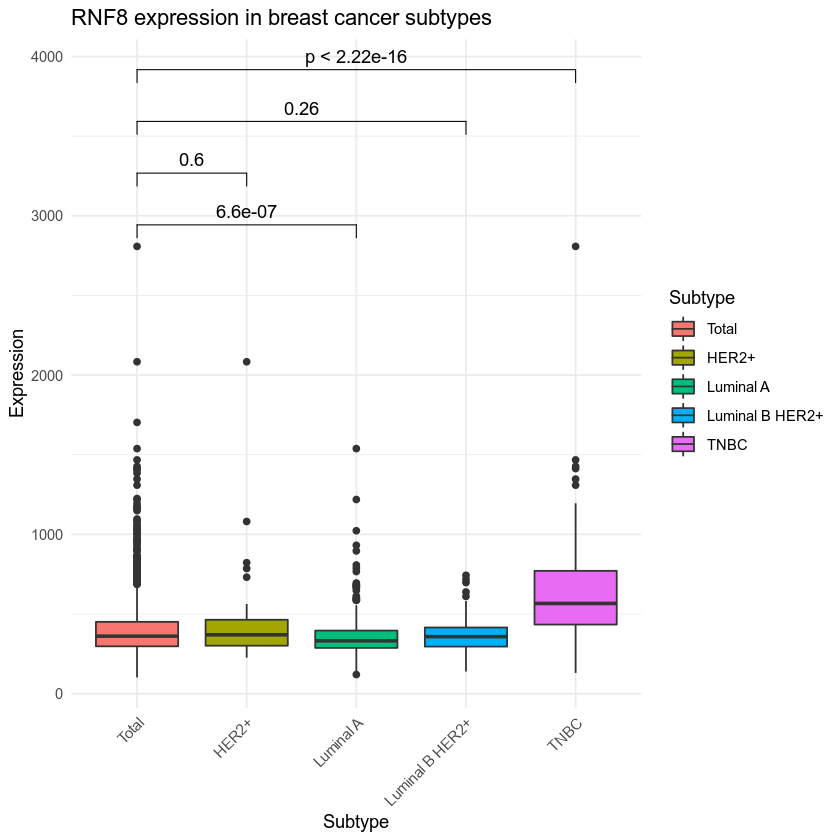

In [67]:
options(repr.plot.width=7, repr.plot.height=7)
consolidated_df %>% dplyr::filter(Hugo_Symbol == 'RNF8') %>% mutate(Subtype = factor(Subtype, levels = c('Total', 'HER2+', 'Luminal A', 'Luminal B HER2+', 'TNBC'))) %>% ggplot(aes(x = Subtype, y = Expression, fill = Subtype)) + geom_boxplot() + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = 'RNF8 expression in breast cancer subtypes', x = 'Subtype', y = 'Expression') + ggpubr::stat_compare_means(comparisons = list(c('Total', 'Luminal A'), c('Total', 'HER2+'), c('Total', 'Luminal B HER2+'), c('Total', 'TNBC')), method = 'wilcox.test', label = 'p.adj')

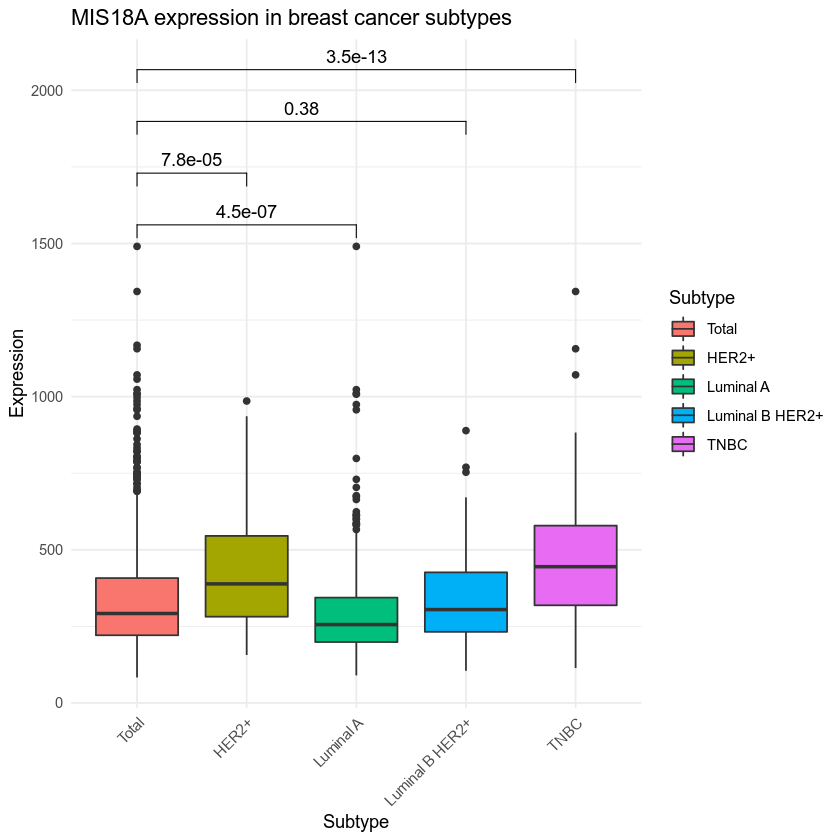

In [66]:
consolidated_df %>% dplyr::filter(Hugo_Symbol == 'MIS18A') %>% mutate(Subtype = factor(Subtype, levels = c('Total', 'HER2+', 'Luminal A', 'Luminal B HER2+', 'TNBC'))) %>% ggplot(aes(x = Subtype, y = Expression, fill = Subtype)) + geom_boxplot() + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = 'MIS18A expression in breast cancer subtypes', x = 'Subtype', y = 'Expression') + ggpubr::stat_compare_means(comparisons = list(c('Total', 'Luminal A'), c('Total', 'HER2+'), c('Total', 'Luminal B HER2+'), c('Total', 'TNBC')), method = 'wilcox.test', label = 'p.adj')

### q25 vs q75 ###

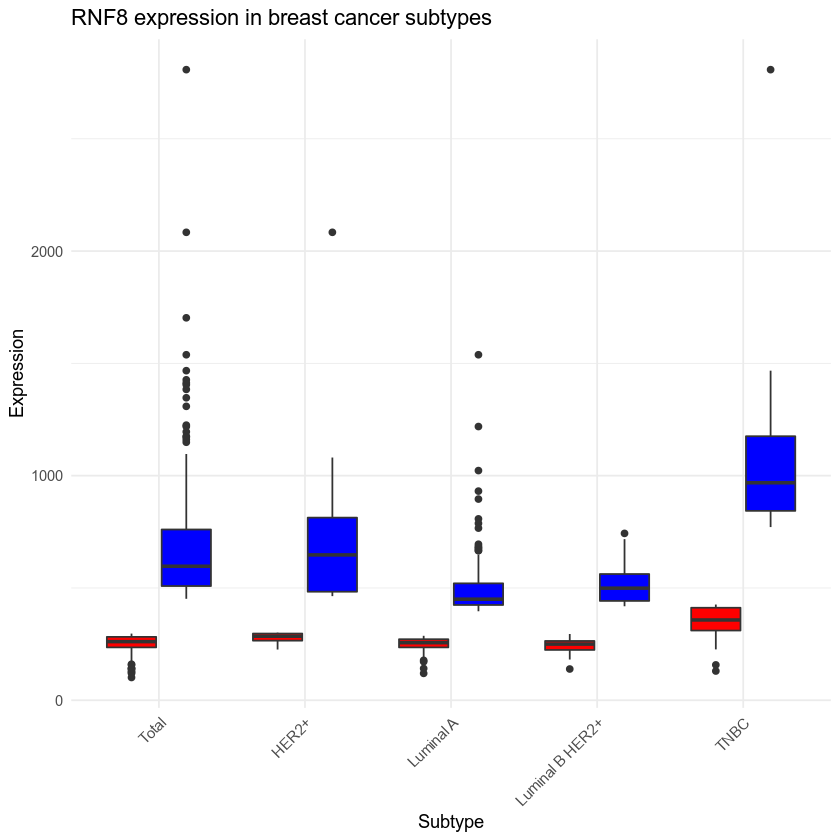

In [6]:
RNF8_subtype_quantiled_exp = consolidated_df %>% dplyr::filter(Hugo_Symbol == 'RNF8') %>% group_by(Subtype) %>% mutate(quantile = case_when(if_all(Expression, function(x) x <= quantile(x, .25)) ~ 'q25', if_all(Expression, function(x) x >= quantile(x, .75)) ~ 'q75', TRUE ~ 'neither')) %>% filter(!quantile == 'neither') %>% mutate(Subtype = factor(Subtype, levels = c('Total', 'HER2+', 'Luminal A', 'Luminal B HER2+', 'TNBC')))
RNF8_subtype_quantiled_exp %>% ggplot(aes(x = Subtype, y = Expression, fill = quantile)) + geom_boxplot() + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = 'RNF8 expression in breast cancer subtypes', x = 'Subtype', y = 'Expression') + scale_fill_manual(values = c('q25' = 'red', 'q75' = 'blue')) + theme(legend.position = 'none')

In [33]:
aa = RNF8_subtype_quantiled_exp %>% filter(Subtype %in% c('Total', 'TNBC')) %>% filter(quantile == 'q75') %>% select(Subtype, Expression)
t.test(aa$Expression ~ aa$Subtype)$p.value

[1] 8.358949e-06

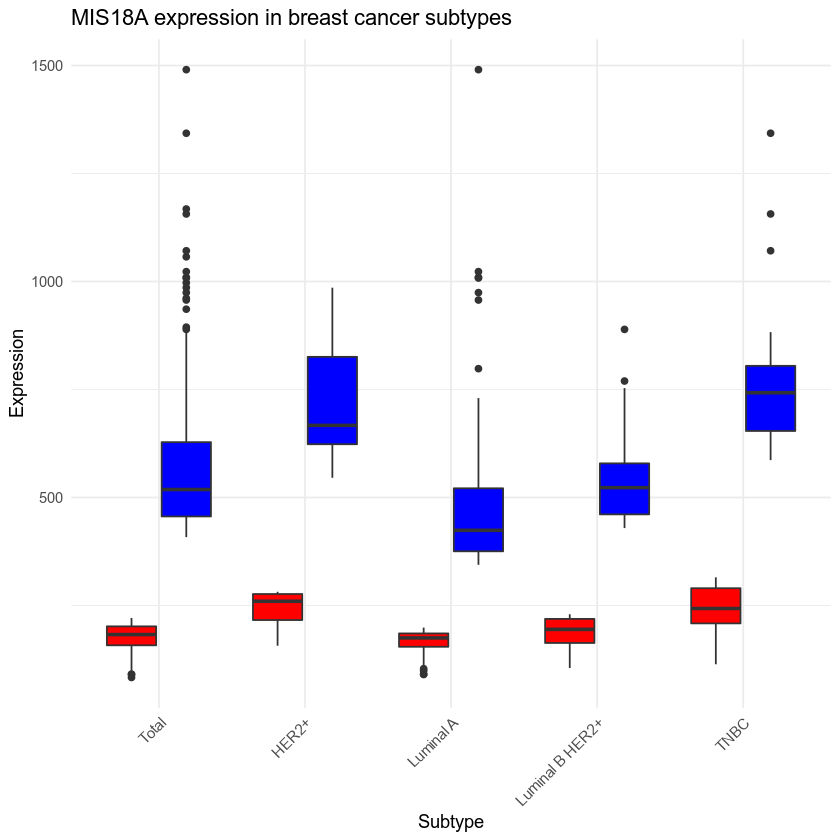

In [7]:
MIS18A_subtype_quantiled_exp = consolidated_df %>% dplyr::filter(Hugo_Symbol == 'MIS18A') %>% group_by(Subtype) %>% mutate(quantile = case_when(if_all(Expression, function(x) x <= quantile(x, .25)) ~ 'q25', if_all(Expression, function(x) x >= quantile(x, .75)) ~ 'q75', TRUE ~ 'neither')) %>% filter(!quantile == 'neither') %>% mutate(Subtype = factor(Subtype, levels = c('Total', 'HER2+', 'Luminal A', 'Luminal B HER2+', 'TNBC')))
MIS18A_subtype_quantiled_exp %>% ggplot(aes(x = Subtype, y = Expression, fill = quantile)) + geom_boxplot() + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = 'MIS18A expression in breast cancer subtypes', x = 'Subtype', y = 'Expression') + scale_fill_manual(values = c('q25' = 'red', 'q75' = 'blue')) + theme(legend.position = 'none')

In [65]:
aa = MIS18A_subtype_quantiled_exp %>% filter(Subtype %in% c('Total', 'TNBC')) %>% filter(quantile == 'q75') %>% select(Subtype, Expression)
t.test(aa$Expression ~ aa$Subtype)$p.value

[1] 1.07271e-06

### q10 vs q90 ###

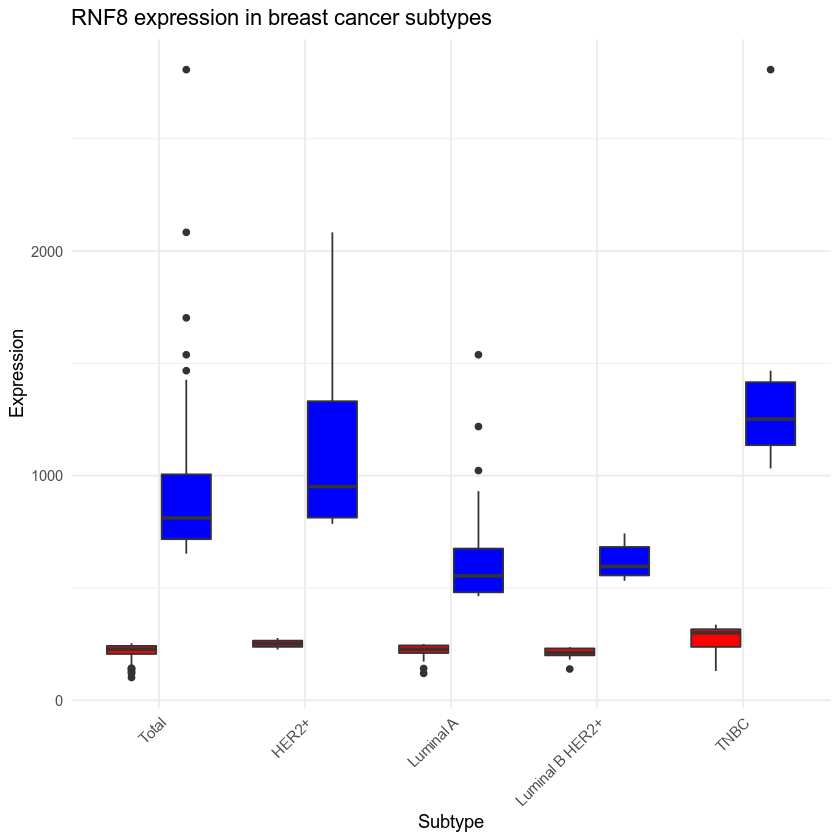

In [10]:
RNF8_subtype_quantiled_exp = consolidated_df %>% dplyr::filter(Hugo_Symbol == 'RNF8') %>% group_by(Subtype) %>% mutate(quantile = case_when(if_all(Expression, function(x) x <= quantile(x, .10)) ~ 'q10', if_all(Expression, function(x) x >= quantile(x, .90)) ~ 'q90', TRUE ~ 'neither')) %>% filter(!quantile == 'neither') %>% mutate(Subtype = factor(Subtype, levels = c('Total', 'HER2+', 'Luminal A', 'Luminal B HER2+', 'TNBC')))
RNF8_subtype_quantiled_exp %>% ggplot(aes(x = Subtype, y = Expression, fill = quantile)) + geom_boxplot() + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = 'RNF8 expression in breast cancer subtypes', x = 'Subtype', y = 'Expression') + scale_fill_manual(values = c('q10' = 'red', 'q90' = 'blue')) + theme(legend.position = 'none')

In [13]:
aa = RNF8_subtype_quantiled_exp %>% filter(Subtype %in% c('Total', 'TNBC')) %>% filter(quantile == 'q90') %>% select(Subtype, Expression)
t.test(aa$Expression ~ aa$Subtype)$p.value

[1] 0.007103426

In [31]:
p.adjust(c(0.00710342631948123, 0.427400403724904, 1.4187699131684e-09, 9.36775604050804e-10), method = 'bonferroni')

[1] 2.841371e-02 1.000000e+00 5.675080e-09 3.747102e-09

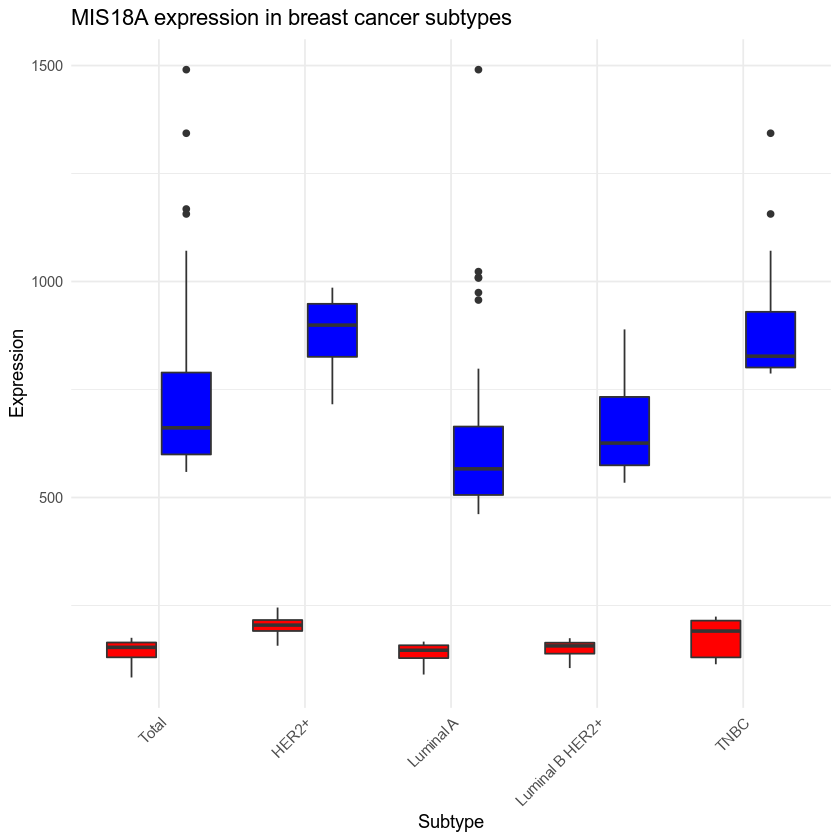

In [9]:
MIS18A_subtype_quantiled_exp = consolidated_df %>% dplyr::filter(Hugo_Symbol == 'MIS18A') %>% group_by(Subtype) %>% mutate(quantile = case_when(if_all(Expression, function(x) x <= quantile(x, .10)) ~ 'q10', if_all(Expression, function(x) x >= quantile(x, .90)) ~ 'q90', TRUE ~ 'neither')) %>% filter(!quantile == 'neither') %>% mutate(Subtype = factor(Subtype, levels = c('Total', 'HER2+', 'Luminal A', 'Luminal B HER2+', 'TNBC')))
MIS18A_subtype_quantiled_exp %>% ggplot(aes(x = Subtype, y = Expression, fill = quantile)) + geom_boxplot() + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = 'MIS18A expression in breast cancer subtypes', x = 'Subtype', y = 'Expression') + scale_fill_manual(values = c('q10' = 'red', 'q90' = 'blue')) + theme(legend.position = 'none')

In [12]:
aa = MIS18A_subtype_quantiled_exp %>% filter(Subtype %in% c('Total', 'TNBC')) %>% filter(quantile == 'q90') %>% select(Subtype, Expression)
t.test(aa$Expression ~ aa$Subtype)$p.value

[1] 0.004763512